____


**project**: `pneumonia prediction`

**date**: `2021-12-09`

**decription:** ``given an image of a chest-x-ray we are gong to predict if the person have pneumonia or not.``

**main:** ``computer vision(cv) pytorch``

**programmer:** `crispen gari`

**architecture:** `multi layer perceptron (mlp)`

**language**: `python`

____


### Pneumonia

There are two types of Pneumonia: 

1. Bacteria Pneumonia
2. Viral Pneumonia


<p align="center"><img src="https://www.news-medical.net/image.axd?picture=2021%2F8%2Fshutterstock_1455103604.jpg" width="100%"/></p>


Using Artificial Intelligence we want to create a simple model that will be able to detect weather a person has `Pneumonia-Bacteria`, `Pneumonia-virus`  or `Normal` given their `chest-x-ray` image.

### Chest X-Ray Images (Pneumonia)

In this notebook we are going to train a Multi Layer Perceptron (MLP) that will detect wether `Pneumonia` infection on images.

This will be a simple basic categorical classification on images using python pytorch and torchvision.



### Dataset

The dataset that i will be using was found on [kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).


The images are uploaded on my google drive so that i can easily load them in my google colab notebook.


### Folder structure:
The images are arranged in the following format in my google drive:

```
📁 chest-exray
    📁  train
      📁  PNEUMONIA_BACTERIA
          ...
      📁  PNEUMONIA_VIRAL
          ...
      📁  NORMAL
          ...
    📁  test'
      📁  PNEUMONIA_BACTERIA
          ...
      📁  PNEUMONIA_VIRAL
          ...
      📁  NORMAL
          ...
    📁  val
      📁  PNEUMONIA_BACTERIA
          ...
      📁  PNEUMONIA_VIRAL
          ...
      📁  NORMAL
          ...

key: ... (images)
```


### Mounting the drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Basic imports

In [ ]:
import torch, random
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'2.0.0+cu118'

### Other imports

In [ ]:
import os
import time
from prettytable import PrettyTable

### Seeds


In [ ]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

Get `gpu` accelaration if posible (cuda)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Image transformations

We are going to load the images using the `datasets.ImageFolder` from `torchvision` so we need to define some transformation on our images for each set. The following transforms are going to be applied to our images in sequence using the `transforms.Compose`

1. train
  * Resize (96, 96)
  * RandomRotation()
  * RandomHorizontalFlip()
  * RandomCrop(96)
  * ToTensor()
  * Grayscale()
  * Normalize() with meand and std = `.5`

2, 3. test/validation
  * Resize (96, 96)
  * ToTensor()
  * Grayscale()
  * Normalize() with meand and std = `.5`




In [ ]:
mean = std = .5

In [ ]:
image_transforms = {
    "train": transforms.Compose([
       transforms.Resize([96,96]),
       transforms.RandomRotation(5),
       transforms.RandomHorizontalFlip(.5),
       transforms.RandomCrop(96, padding=2),
       transforms.ToTensor(),
       transforms.Grayscale(
         num_output_channels =1
       ),
       transforms.Normalize(mean=[mean], std=[std], inplace=False)                         
    ]),
    "val": transforms.Compose([
        transforms.Resize([96,96]),
        transforms.ToTensor(),
        transforms.Grayscale(
         num_output_channels =1
       ),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)
    ]),
    "test": transforms.Compose([
        transforms.Resize([96,96]),
        transforms.ToTensor(),
        transforms.Grayscale(
         num_output_channels =1
       ),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)
    ])
}

### Base path to where the images are

The base path where our images sets are is declared in the following code cell: 

In [ ]:
base_path = "/content/drive/My Drive/Computer Vision/chest-exray"
os.listdir(base_path)

['test', 'train', 'val']

### Creating a dataset

We are then going to create a `image_dataset` wich will contain all the our three sets `train`, `test` and `val`.

In [ ]:
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(base_path, x),
        transform = image_transforms[x]
    ) for x in os.listdir(base_path)
}

### Class names

In [ ]:
class_names = image_datasets["train"].classes
class_names

['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRAL']

In [ ]:
def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [ ]:
train_data = image_datasets["train"]
val_data = image_datasets["val"]
test_data = image_datasets["test"]

### Class names to index

In [ ]:
train_data.class_to_idx

{'NORMAL': 0, 'PNEUMONIA_BACTERIA': 1, 'PNEUMONIA_VIRAL': 2}

### Counting examples in each set.

In [ ]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = ("train", len(train_data)), ("test", len(test_data)), ("val", len(val_data))
tabulate(columns, data_rows, title)

+-------+-------+
| SET   | TOTAL |
+-------+-------+
| train |  5442 |
| test  |  1135 |
| val   |  1135 |
+-------+-------+


### A helper function that visualize images.

In [ ]:
def plot_images(images, labels, cols=5):
  rows = 4
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, (image, label) in enumerate(zip(images, labels)):
      plt.subplot(rows, cols, i + 1)
      plt.axis('off')
      plt.imshow(image.view(96, 96), cmap="gray")
      plt.title(class_names[label], color ='k', fontsize=16 )

In [ ]:
images = [image for image, label in [train_data[i] for i in range(32)] ]
labels = [label for image, label in [train_data[i] for i in range(32)] ]


### Visualizing images

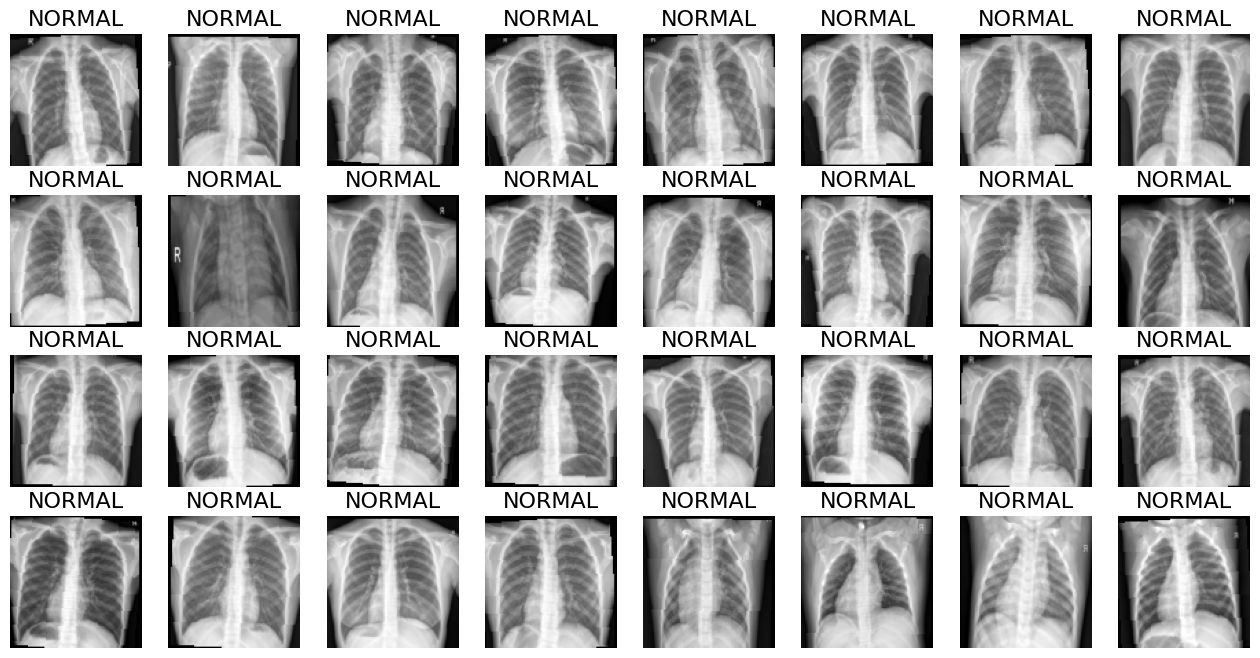

In [ ]:
plot_images(images, labels, cols=8)

### Creating iterators

We are going to create iterators for all our 3 datasets with a batch size of `64`

In [ ]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE
                                 )
valid_iterator = data.DataLoader(val_data,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE
                                 )
test_iterator = data.DataLoader(test_data,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE
                                 )

### Creating the model.

We are going to create the `Multi Layer Perceptron(MLP)` model that will do the categorical classification of our images.

The model (MLP) will consist of `Linear` layers aka (FC) layers and a Dropout layer.

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=.5):
    super(MLP, self).__init__()
    self.input_fc = nn.Linear(input_dim, 250)
    self.hidden_fc = nn.Linear(250, 100)
    self.output_fc = nn.Linear(100, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    # x = [batch size, height, width]
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    # x = [batch size, height * width]
    x = F.relu(self.input_fc(x)) # x = [batch size, 250]
    x = self.dropout(x)
    x = F.relu(self.hidden_fc(x)) # x = [batch size, 100]
    x = self.dropout(x)
    outputs = self.output_fc(x) # x = [batch_size, output_dim]
    return outputs, x

### Model instance

The input dim will be `96x96` and the output dim will be `3`. 

In [ ]:
INPUT_DIM = 96 * 96
OUTPUT_DIM = 3
dropout = .5
model = MLP(INPUT_DIM, OUTPUT_DIM, dropout).to(device)
model

MLP(
  (input_fc): Linear(in_features=9216, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Counting the model parameters

In [ ]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
count_params(model)

+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     |  2,329,653 |
| trainable parameters |  2,329,653 |
+----------------------+------------+


### Optimizer

For the optimizer we are going to use `Adam` with default parameters.

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

### Criterion
For the criterion/loss function we are going to use the `CrossEntropyLoss`.

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)

### Categorical accuracy function

This function will calculate a accuracy for the predicted labels aganist the actual labels.

In [ ]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  return correct.float()/y.shape[0]

### Training and Evaluation functions

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Visulizing tranning

We are going to create a helper function that will tabulate training every epoch.

In [ ]:
def hms_string(sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60 * 60)) / 60)
  s = sec_elapsed % 60
  return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
def tabulate_training(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

### Training loop 

We are then going to run our training loop as save the model when the previous validation loss is less that the current validation loss. We are only going to train the model for `10` epochs.

In [ ]:
EPOCHS = 20
best_valid_loss = float('inf')
MODEL_NAME = "chest-x-ray.pt"
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
last_saved_epoch = 1

training_start = time.time()
for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  save_status = "(not saving)"
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    save_status = "(saving)"
    last_saved_epoch = epoch + 1
    torch.save(model.state_dict(), MODEL_NAME)
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  
  title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
  print(save_status)
  tabulate_training(column_names, data_rows, title)
  
training_end = time.time()


(saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.838 |   61.99% | 0:02:09.66 |
| Validation | 0.735 |   67.98% |            |
+------------+-------+----------+------------+
(saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.716 |   68.93% | 0:02:05.30 |
| Validation | 0.733 |   67.48% |            |
+------------+-------+----------+------------+
(saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.672 |   70.88% | 0:02:02.75 |
| Validation | 0.689 |   69.20% |            |
+------------+-------+----------+------------+
(not saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+------

IndexError: ignored

Next we are going to evaluate the best model and check for the model `loss` and `accuracy` based on the unseen dataset which is the `test`.

In [ ]:
model.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_training(column_names, data_rows, title)


+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.689 |   69.20% |            |
+------+-------+----------+------------+


### Downloading the best model

We are going to download the saved model as a file in the following code cell.

In [ ]:
from google.colab import files
files.download(MODEL_NAME)

### Model inference

For model inference we are going to take in an image and make predictions on it.


### Image preprocessing

For image preprocessing we are going to use `torchvision` transforms so that we tranform our image in the way we want it.

1. Given an image resize it to `96x96`
2. Convert the image to tensor 
3. convert the image to grayscale

> _Note that during image processing we should use `.5` as our ``mean`` and `std` since we used this during our train transforms._




In [ ]:
from PIL import Image

In [ ]:
def preprocess_img(img):
  """
  takes in a pillow image and pre process it
  """
  preproces_1 =  nn.Sequential(
   transforms.Resize([96,96]),
   transforms.Grayscale(1)
  )
  preprocess_2 =  nn.Sequential(
    transforms.Normalize(mean=[mean], std=[std], inplace=False)
  )
  img = preprocess_2(transforms.ToTensor()(preproces_1(img)))
  return img

In [ ]:
img_path = os.path.join(base_path, "train/PNEUMONIA_BACTERIA/person1_bacteria_1.jpeg")
pil_img = Image.open(img_path)
img = preprocess_img(pil_img)

### Predict method

The predict method will take in the following args: 

1. model
2. image (processed image)
3. device (cuda or cpu)

In [ ]:
def predict(model, image, device):
  image = image.to(device)
  preds, _ = model(image)
  preds = F.softmax(preds, dim=1).detach().cpu().numpy().squeeze()

  predicted_label = np.argmax(preds)

  all_preds = [
      {
      'label': i,
      'class_label': class_names[i],
      'probability': np.round(preds[i], 2),
      } for i, _ in enumerate(preds)
  ]

  res ={
      'label': predicted_label,
      'class_label': class_names[predicted_label],
      'probability': np.round(preds[predicted_label], 2),
      'predictions': all_preds
  }
  return res

predict(model, img, device)

### Model Evaluation metrics

In this section we are going to evaluate the best model and visualize the matrics. We are going to use the following evaluation methods on this classification task.

1. confusion matrix
2. classification report.


First of all we need to get the actual values and predicted values from the `test_iteraror` so that we will be able to use all the examples in the `test` dataset to evaluate our model. We are going to define a function called `get_predictions` this function will take in the `model`, `iterator` and `device` as parameter and return the following lists of values:

1. images - the image to be predicted
2. labels - the actual image label
3. probs - the list of probabilities for the image to belong to a certain class.



In [ ]:
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

Let's go ahead and get the `images`, `labels` and `probabilities` from the `test_iterator` using our `get_predictions` function

In [ ]:
test_images, test_labels, probs = get_predictions(model, test_iterator, device)

The `probs` are not the predicted labels, it is a torch tensor of size `3` that looks as follow:

```
tensor([0.8013, 0.1063, 0.0924])
```
So these are just probabilities that are telling us that, the predicted image has `~80%` chance of belonging to class `0`, `~11%` chance of belonging to class `1` and `9%` chance of belonging to class 2. Basically the model is telling us that, I think the image you gave me belongs to class `0`. 


To get the predicted values from the images in the `test_set` we need to use the `torch.argmax()` function which returns us the index with the highest number in a `torch tesnor`. We are going to calculate the `argmax` of our probability in the `first` dimenion to get all the predicted values labels as follows:

In [ ]:
pred_labels = torch.argmax(probs, 1)
pred_labels

### Ploting predictions

Now that we have our `predicted` labels and `real` labels from the `test` dataset. We can use them to visualize how good the model is performing during inference. Let's define a function called `plot_predictions_images` which plots the predicted images together with their labels.

In [ ]:
images = test_images
labels = test_labels.numpy()
preds = pred_labels.numpy()

In [ ]:
def plot_predictions_images(images_and_classes, 
                            labels_true, labels_pred, 
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image.view(96, 96), cmap="gray")
        plt.title(class_names[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=10 )

plot_predictions_images(images[:24], labels[:24], preds[:24], cols=8)


From the above visualization the images that has a `red` title are mis-predicted by the model.

#### The confusion matrix

Let's create a confusion matrix as a way of visualizing how good our model is when it comes to predicting images in the `test` dataset. We are going to define a function called `plot_confusion_matrix` in the following code cell, this function will take in the real-labels, predicted labels together with the classes (textual labels e.g, normal)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools

In [ ]:
def plot_confusion_matrix(labels: list= [], pred_labels:list =[], classes:list=[]):
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  cm = confusion_matrix(labels, pred_labels)

  if len(classes) == 0:
    classes = labels.numpy()

  cm = ConfusionMatrixDisplay(cm, display_labels= classes)
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  plt.xticks(rotation = 0, color="black", fontsize=10)
  plt.yticks(rotation = 0, color="black", fontsize=10)

In [ ]:
plot_confusion_matrix(labels, preds, class_names)

### Classification report

In the following code cell we are going to print the classification report as a way of measuring how good our model was in predicting (normal, pneumonia-virus and pneumonia-bacteria).

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
cr = classification_report(labels, preds, output_dict=False, labels=labels, target_names =[class_names[i] for i in labels])
print(cr)